# Digit Recognizer

<img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSuIlRkBkpLaREje3lUC7m_xOYlQpzD9K1zOA&s">



## Problemin Tanımı
Bu proje, **Kaggle Digit Recognizer** yarışması kapsamında el yazısı rakamların (0-9) sınıflandırılmasını amaçlar.
## Sınıfların Açıklaması
* **0-9:** Toplam 10 sınıf.
## Değerlendirme Metriği
Yarışma **Categorization Accuracy** metriği ile değerlendirilmektedir.


# Veri Yükleme


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(42)
tf.random.set_seed(42)

DATA_DIR = '../data'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')


C:\Users\Erhan\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
try:
    train_df = pd.read_csv(TRAIN_PATH)
    test_df = pd.read_csv(TEST_PATH)
    print(f'Train Shape: {train_df.shape}')
    print(f'Test Shape: {test_df.shape}')
except FileNotFoundError:
    print('HATA: Dosyalar bulunamadı.')
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()


Train Shape: (42000, 785)
Test Shape: (28000, 784)


# Veri Setinin Yapısal İncelemesi


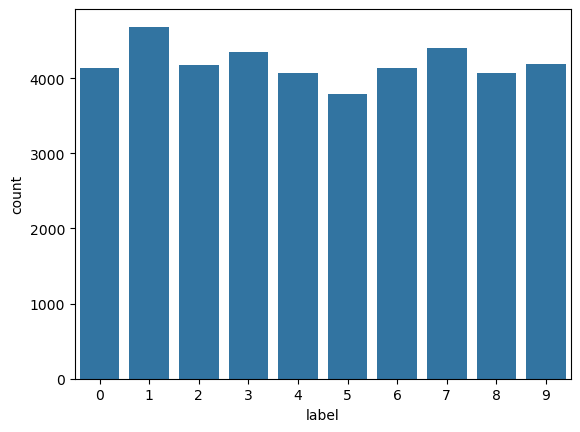

In [3]:
if not train_df.empty:
    Y_train_full = train_df['label']
    X_train_full = train_df.drop(columns=['label'])
    sns.countplot(x=Y_train_full)
    plt.show()


In [4]:
if not train_df.empty:
    print(f'Eksik Değerler: {X_train_full.isnull().sum().sum()}')


Eksik Değerler: 0


# EDA (Exploratory Data Analysis)


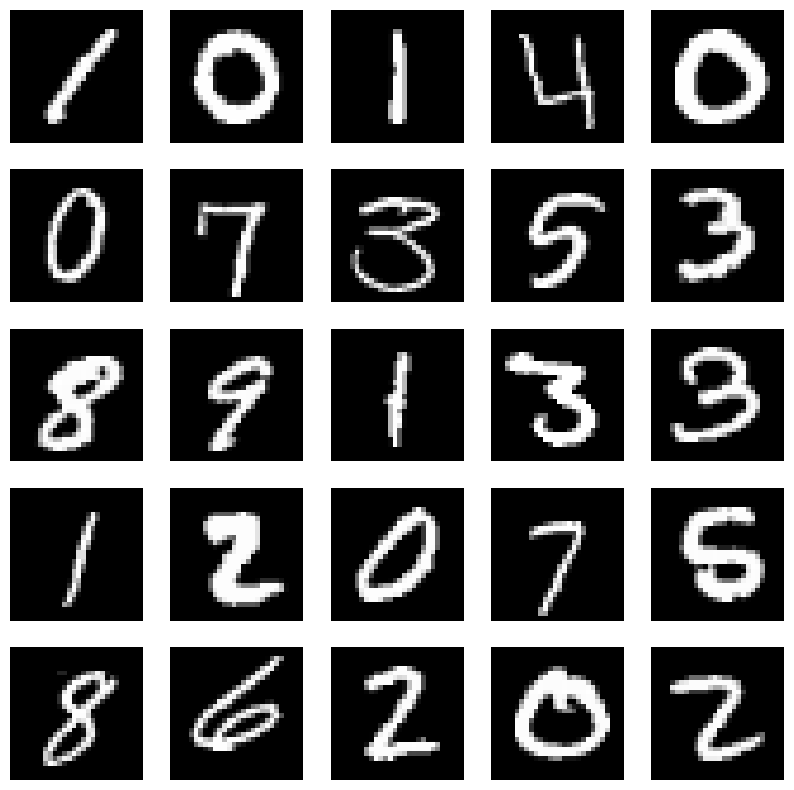

In [5]:
if not train_df.empty:
    X_train_images = X_train_full.values.reshape(-1, 28, 28)
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(X_train_images[i], cmap='gray')
        plt.axis('off')
    plt.show()


# Feature Engineering & Preprocessing


In [6]:
if not train_df.empty:
    # 1. Normalize
    X_train_full = X_train_full / 255.0
    test_df = test_df / 255.0
    
    # 2. Reshape
    X_train_full = X_train_full.values.reshape(-1, 28, 28, 1)
    X_test = test_df.values.reshape(-1, 28, 28, 1)
    
    # 3. Label Encoding
    from tensorflow.keras.utils import to_categorical
    Y_train_full = to_categorical(Y_train_full, num_classes=10)
    print('Preprocessing Tamamlandı.')


Preprocessing Tamamlandı.


# Train-Test Split


In [7]:
if not train_df.empty:
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train_full, Y_train_full, test_size=0.1, random_state=42
)


# Modelleme (CNN)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Define the improved model
model = Sequential()

# Block 1
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

C:\Users\Erhan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Erhan\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


In [15]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,      # Randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,       # Randomly zoom image 
        width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # Randomly flip images
        vertical_flip=False)    # Randomly flip images

datagen.fit(X_train)

# Fit the model with the generator
history = model.fit(datagen.flow(X_train, Y_train, batch_size=86),
                              epochs=30, # Increased epochs for better convergence
                              validation_data=(X_val, Y_val),
                              verbose=2,
                              steps_per_epoch=X_train.shape[0] // 86,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
439/439 - 43s - 98ms/step - accuracy: 0.8627 - loss: 0.5323 - val_accuracy: 0.7817 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 2/30


C:\Users\Erhan\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


439/439 - 2s - 4ms/step - accuracy: 0.9884 - loss: 0.0286 - val_accuracy: 0.7876 - val_loss: 0.9482 - learning_rate: 0.0010
Epoch 3/30
439/439 - 38s - 87ms/step - accuracy: 0.9513 - loss: 0.1918 - val_accuracy: 0.9833 - val_loss: 0.0682 - learning_rate: 0.0010
Epoch 4/30
439/439 - 2s - 3ms/step - accuracy: 0.9651 - loss: 0.0800 - val_accuracy: 0.9824 - val_loss: 0.0719 - learning_rate: 0.0010
Epoch 5/30
439/439 - 38s - 86ms/step - accuracy: 0.9639 - loss: 0.1516 - val_accuracy: 0.9879 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 6/30
439/439 - 2s - 4ms/step - accuracy: 1.0000 - loss: 0.0334 - val_accuracy: 0.9876 - val_loss: 0.0533 - learning_rate: 0.0010
Epoch 7/30
439/439 - 39s - 89ms/step - accuracy: 0.9686 - loss: 0.1309 - val_accuracy: 0.9871 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 8/30

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
439/439 - 2s - 4ms/step - accuracy: 0.9651 - loss: 0.0449 - val_accuracy: 0.9867 - val_loss: 0.0619 - learn

# Değerlendirme


132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


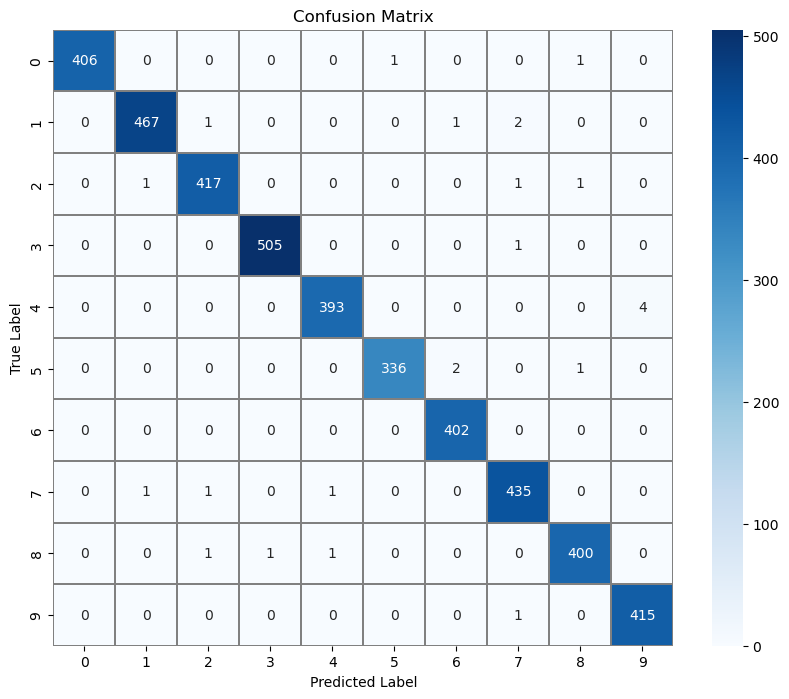

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       408
           1       1.00      0.99      0.99       471
           2       0.99      0.99      0.99       420
           3       1.00      1.00      1.00       506
           4       0.99      0.99      0.99       397
           5       1.00      0.99      0.99       339
           6       0.99      1.00      1.00       402
           7       0.99      0.99      0.99       438
           8       0.99      0.99      0.99       403
           9       0.99      1.00      0.99       416

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Blues", linecolor="gray", fmt='.0f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print detailed classification report
print(classification_report(Y_true, Y_pred_classes))

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


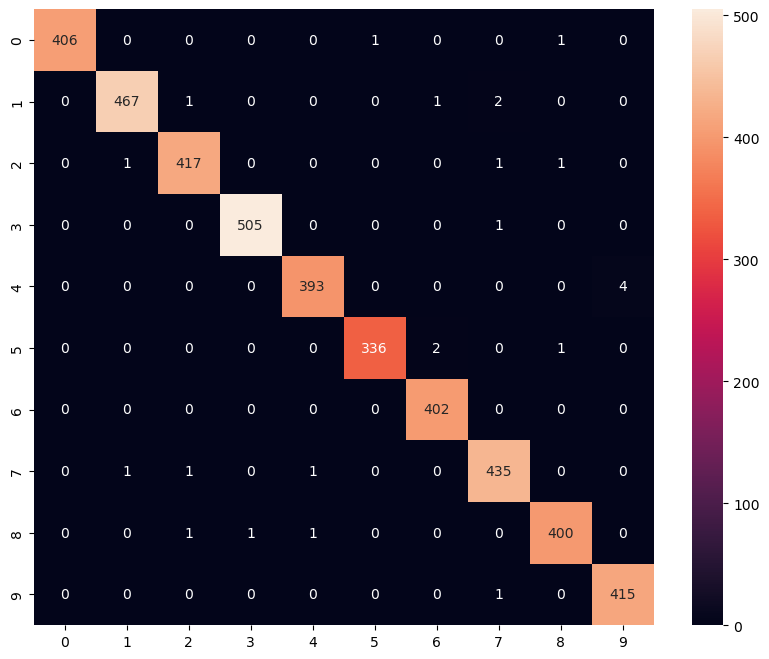

In [17]:
if not train_df.empty:
    Y_pred = model.predict(X_val)
    Y_pred_classes = np.argmax(Y_pred, axis=1) 
    Y_true = np.argmax(Y_val, axis=1) 
    cm = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()


# Model Kaydetme


In [18]:
if not train_df.empty:
    os.makedirs('../models', exist_ok=True)
    model.save('../models/best_model.keras')
    print('Model Saved.')


Model Saved.


# Submission


In [19]:
if not test_df.empty:
    results = model.predict(X_test)
    results = np.argmax(results, axis=1)
    submission = pd.DataFrame({'ImageId': range(1, len(results)+1), 'Label': results})
    os.makedirs('../outputs', exist_ok=True)
    submission.to_csv('../outputs/submission1.csv', index=False)
    display(submission.head())


875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


### Submission Description
Baseline CNN model.
